In [11]:
from IPython.display import Image, display

import base64
import pathlib
import time
import tomllib

import cv2
from openai import OpenAI

from elevenlabs import save as elevenlabs_save
from elevenlabs.client import ElevenLabs

In [2]:
config_path = pathlib.Path("../config.toml")

if not config_path.exists():
    raise FileNotFoundError("config.toml not found")

with open(config_path, "rb") as f:
    config = tomllib.load(f)

In [3]:
openai_api_key = config["openai"]["api_key"]


# This part based on
# https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding
openai = OpenAI(api_key=openai_api_key)


In [4]:
source_path = pathlib.Path("../IMG_0998.MOV")

source_video = cv2.VideoCapture(source_path)

base_64_frames = []
while source_video.isOpened():
    success, frame = source_video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base_64_frames.append(base64.b64encode(buffer).decode("utf-8"))

source_video.release()
print(len(base_64_frames), "frames read.")


7304 frames read.


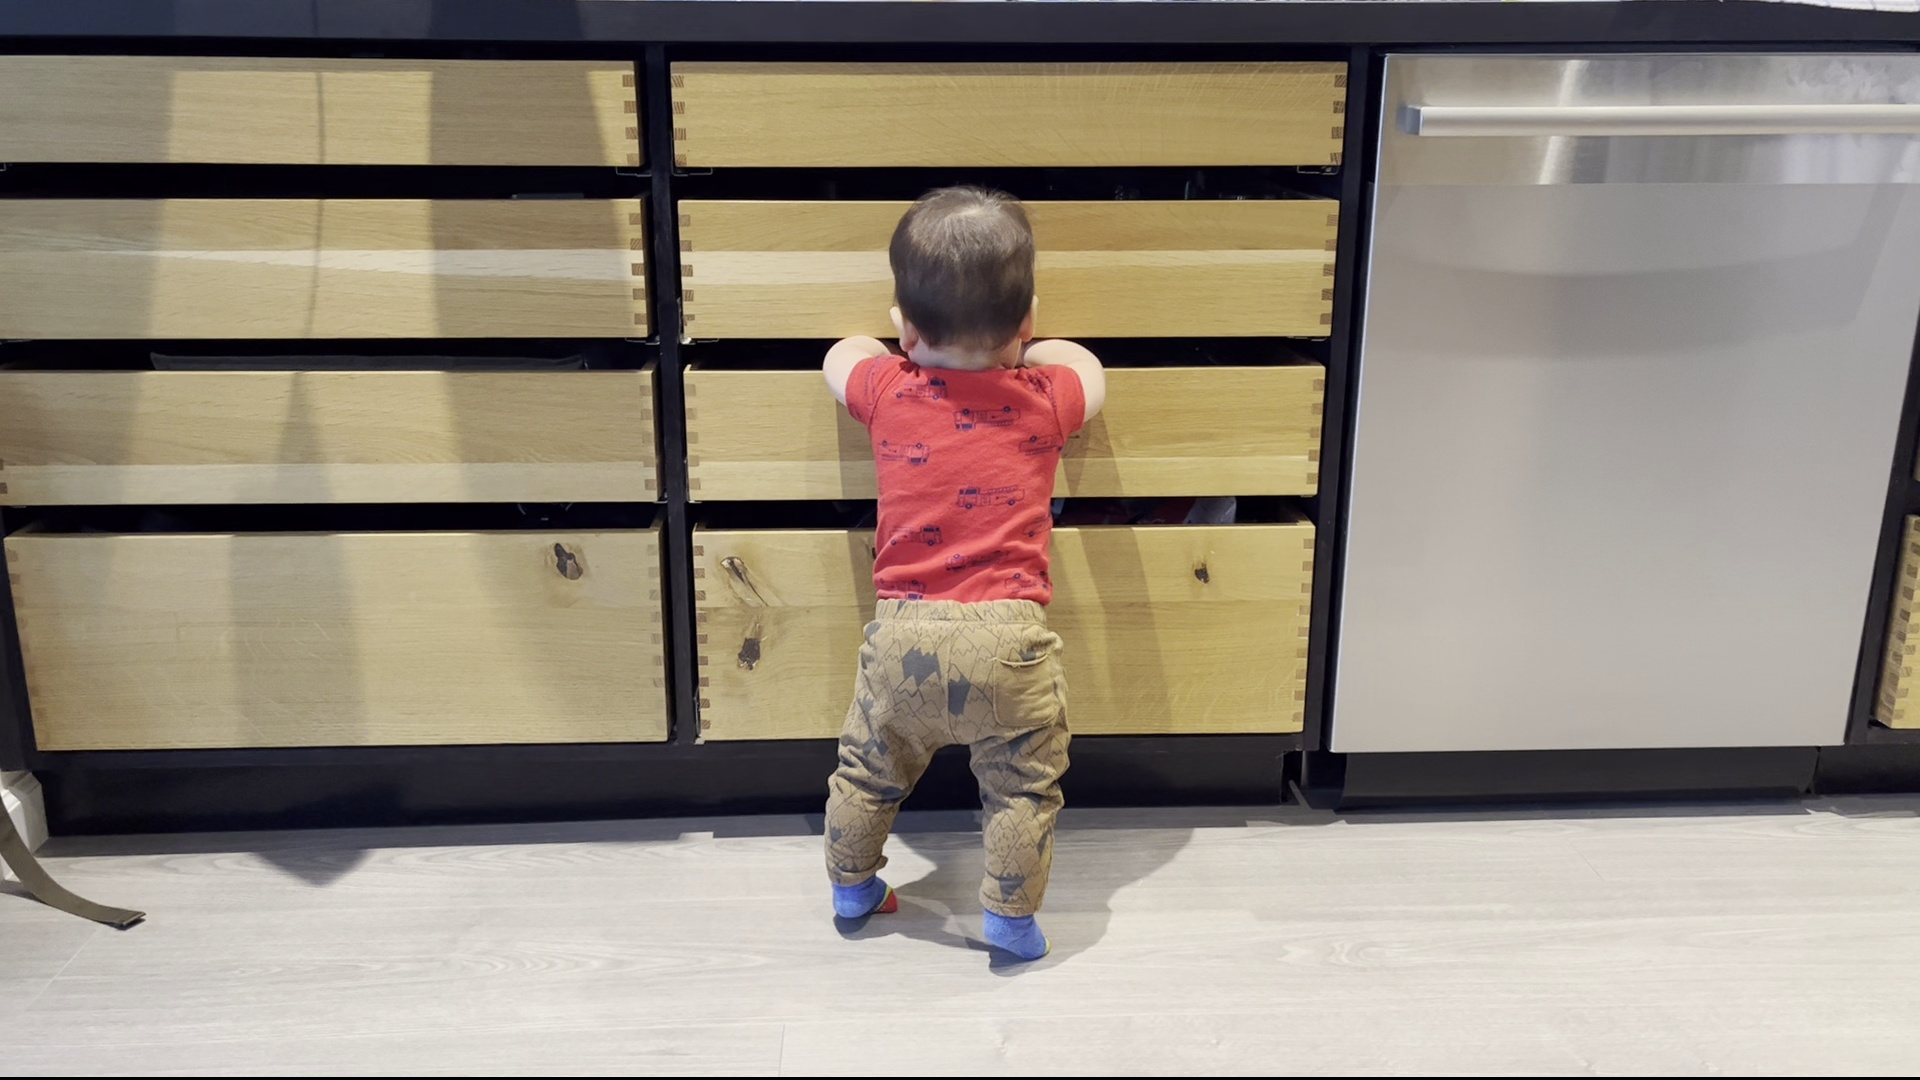

In [5]:
display_handle = display(None, display_id=True)
for i in range(10):
    img = base_64_frames[i*60]
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [8]:
frame_freq = 30 * 8
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            (
                "These are frames from a video. Create a short voiceover script in the "
                "style of David Attenborough narrating a BBC nature documentary. "
                "Only include the narration."
            ),
            *map(lambda x: {"image": x, "resize": 768}, base_64_frames[0::frame_freq]),
        ],
    },
]
openai_params = {
    "model": "gpt-4o",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 2000,
}

result = openai.chat.completions.create(**openai_params)
script = result.choices[0].message.content
print(script)


In the heart of a modern habitat, a young explorer begins his journey.

Here, we see the intrepid juvenile leaning against sturdy wooden terrain. These drawers, packed with hidden treasures, present new opportunities for learning and discovery.

As he navigates the environment, he employs a different technique, lowering himself to the ground and proceeding with a cautious yet determined crawl. Each movement, a testament to his growing strength and coordination.

He traverses from one corner to another, exploring the various landscapes of the living area. On a patch of soft, colorful terrain, he stops momentarily, taking in his surroundings, ever curious, ever vigilant.

The young adventurer then encounters an obstacle—a tall and towering adult. Undeterred, he reaches out, seeking both support and connection, exemplifying the bond between young and old.

Embraced in the secure arms of his elder, our explorer takes in the world from a different perspective. Moments like these are crucial

In [9]:
elevenlabs = ElevenLabs(
  api_key=config["elevenlabs"]["api_key"],
)

audio = elevenlabs.generate(
  text=script,
  voice=config["elevenlabs"]["voice"],
  model="eleven_monolingual_v1"
)

In [12]:
elevenlabs_save(audio, "narration.mp3")